<center> <h1> Classifier on cell profiles </center> </h1>

# 1) Table preparation
## a) Load & join

In [1]:
import polars as pl
import pandas as pd

import numpy as np

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import get_features as gf
import Data_filtering.plot_distribution_table as pdt

from features_engineering import features_drop_corr
from features_engineering import features_drop_corr_gpu
from features_engineering import StandardScaler_group
from features_engineering import StandardScaler_pandas

import xgboost as xgb
from xgboost import XGBClassifier

from tqdm import tqdm
import cupy as cp
from ray import train, tune

In [2]:
metadata = pl.read_csv("Data_filtering/target2_metadata")
features = gf.load_features('COMPOUND', metadata.lazy())

In [3]:
print(" Using Target2:\n"
" feature shape:",
f"{features.select(pl.count()).collect().item()}\n",
f"metadata shape: {metadata.shape[0]}")

 Using Target2:
 feature shape: 20597
 metadata shape: 27916


metadata should be filtered out. 

In [4]:
metadata = metadata.join(features.select(pl.col("^Metadata.*$")).collect(),
              on=["Metadata_Source", "Metadata_Plate", "Metadata_Well", "Metadata_JCP2022"],
              how="inner")


## b) distribution of the resulting table

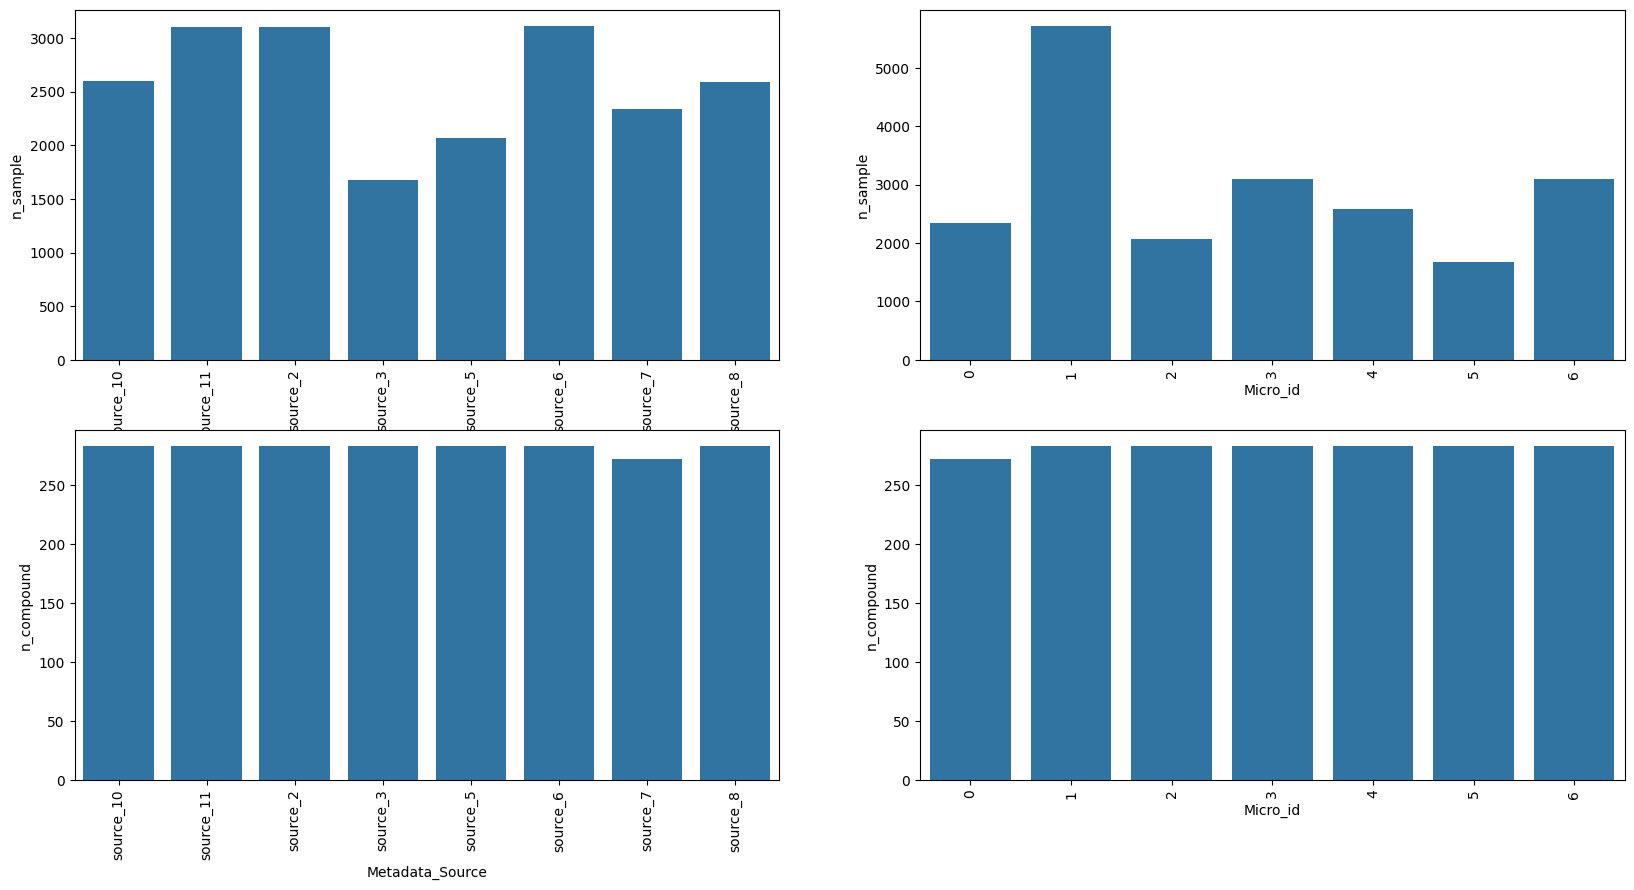

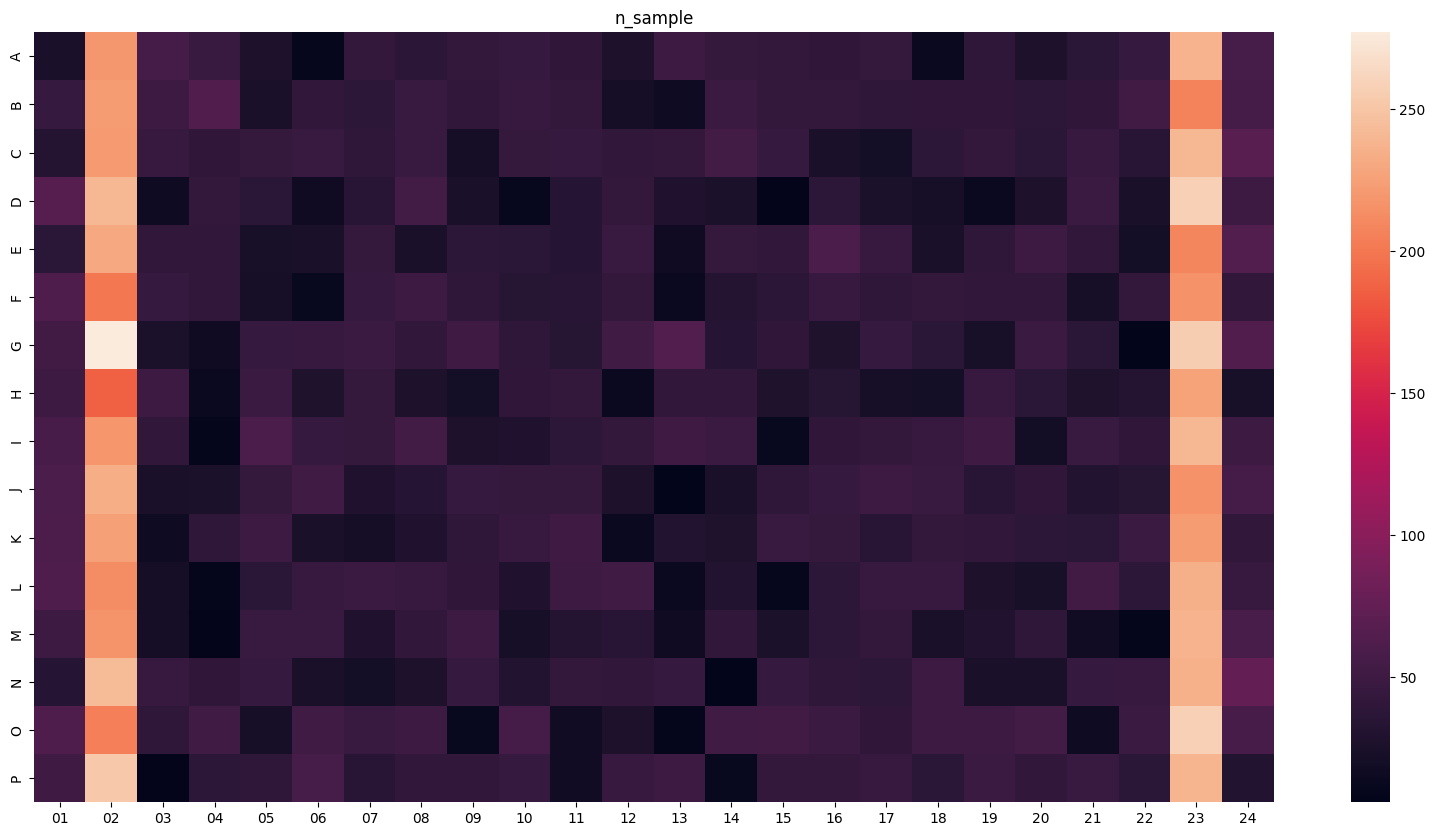

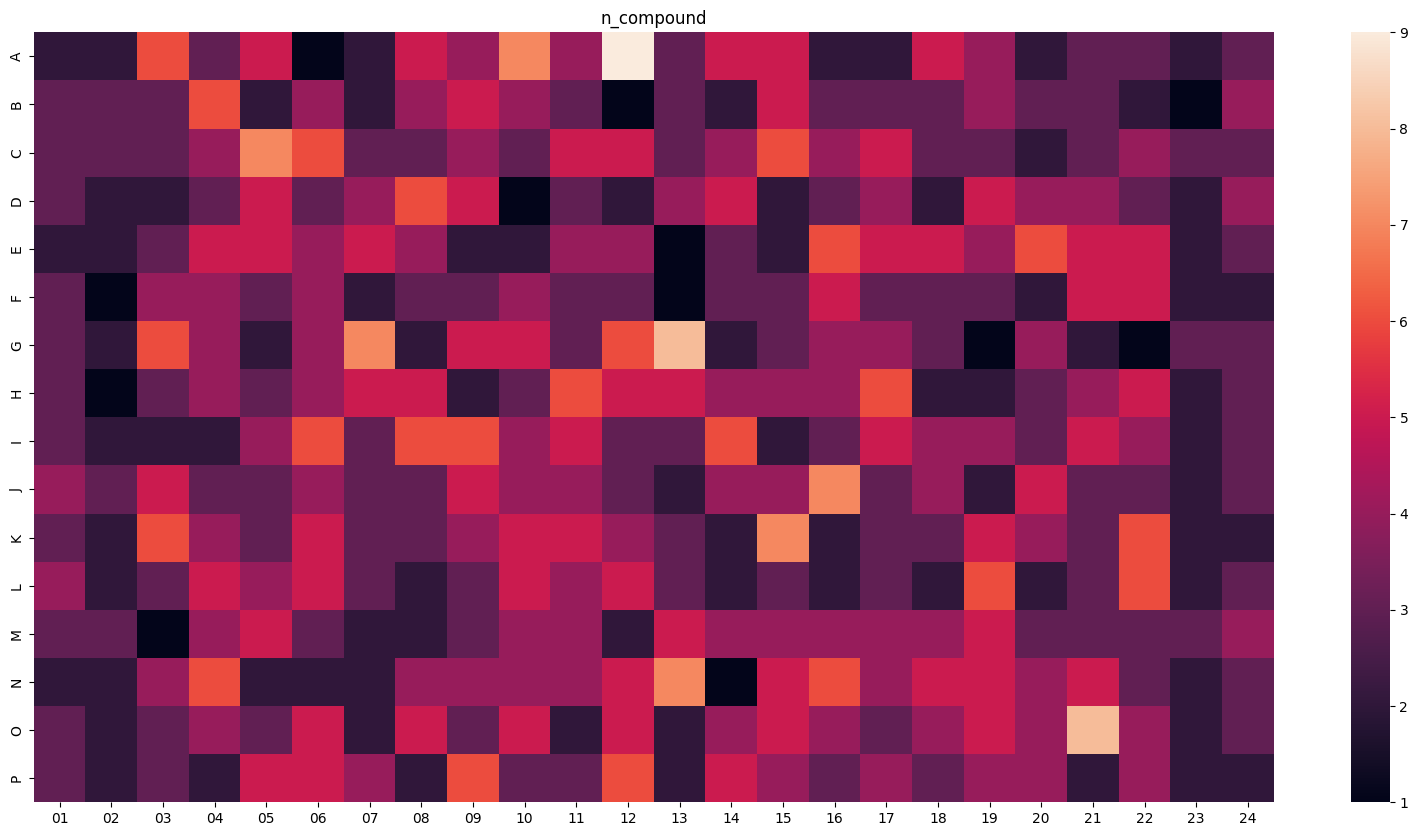

In [5]:
pdt.show_distribution(metadata)

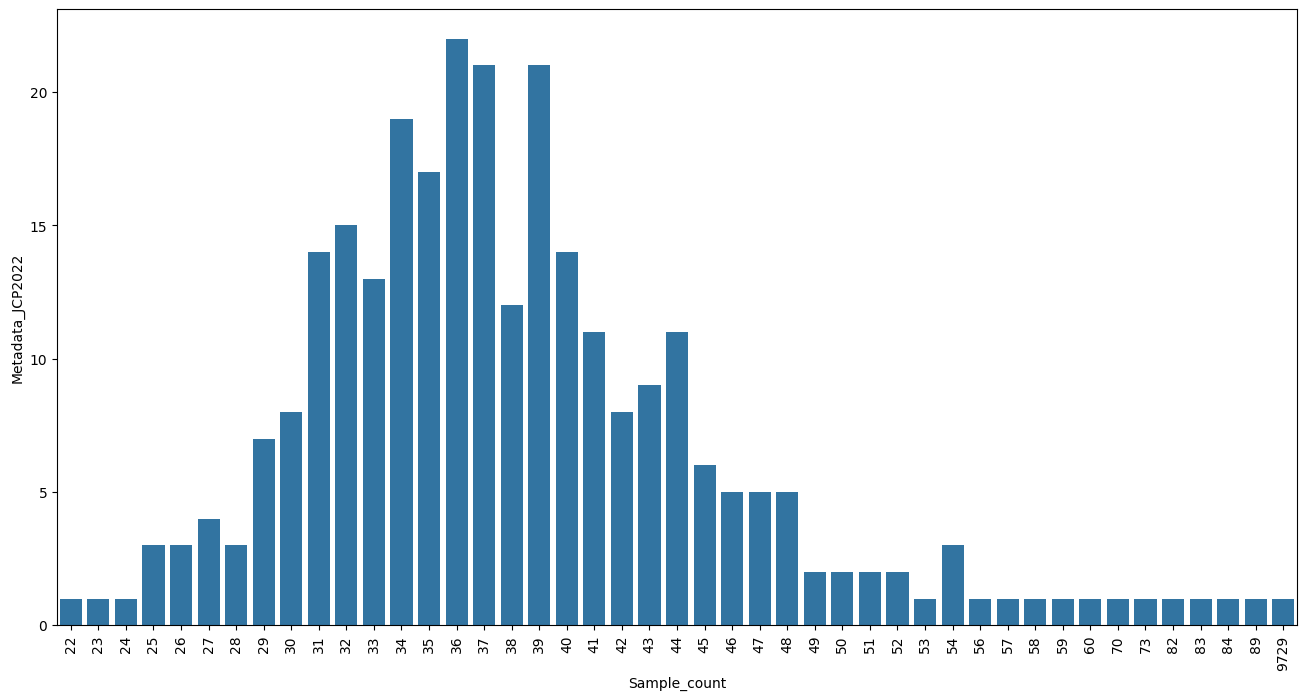

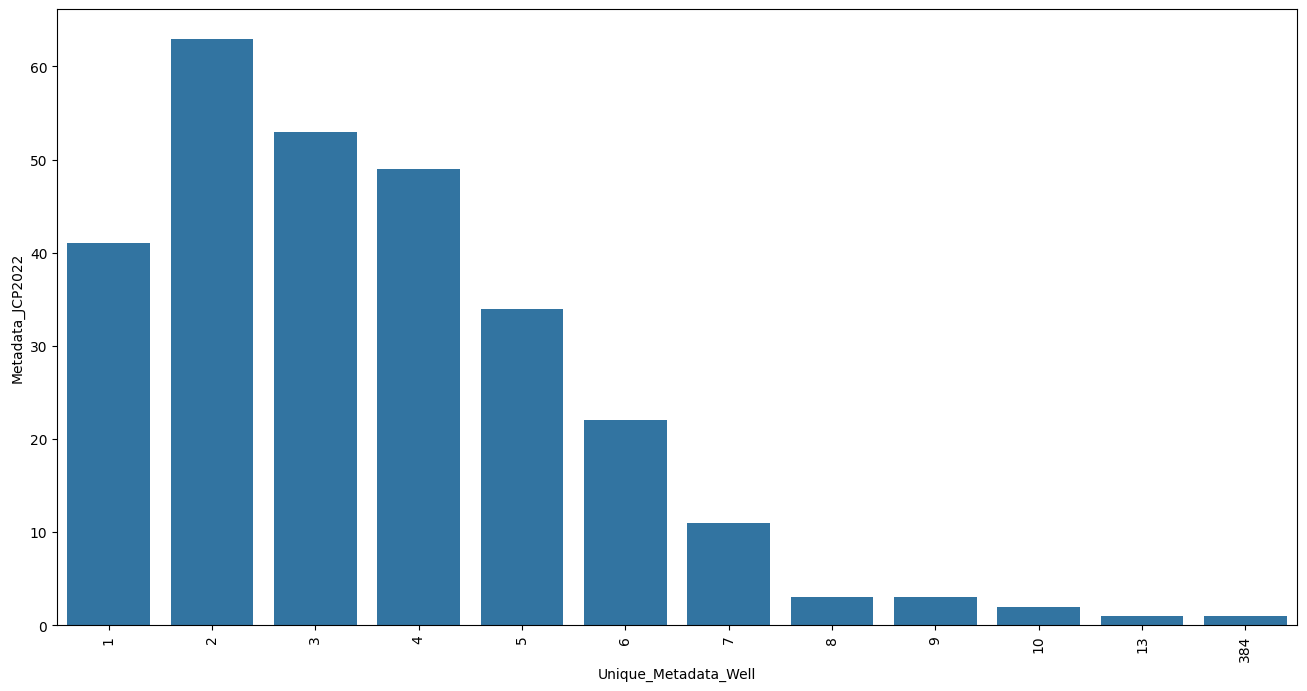

In [6]:
pdt.compound_info(metadata)

In [7]:
metadata_trt = metadata.filter(pl.col("pert_iname") != "DMSO")

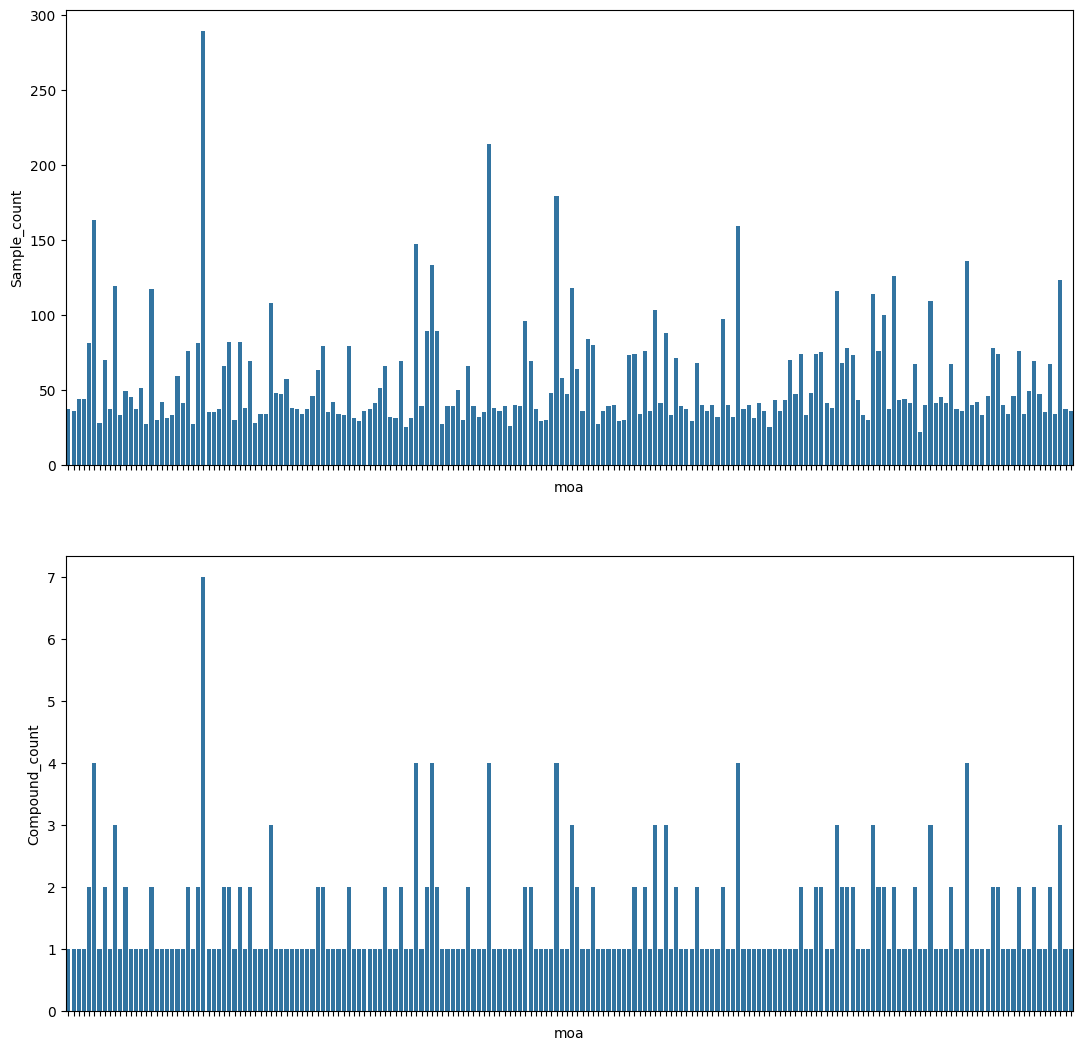

In [8]:
pdt.moa_distribution(metadata_trt)

### i) Some remark on the moa
Some moa present multiple moa, separated with '|'.
2 ideas: 
* Assume those composed moa are unique moa in a sense ans say it is a different class in itself.
* Assume these moa are just not fully determined:
  - Then Samples may either have multiple class: if the classifier 'wrongly' assign a singleclass to a multiple class sample, then if this class is within the multiple class, this is not an error.
  - We decide to assign a single class to those sample: either randomly, either with a specific reason in mind.

#### For the sake of simplicity, just assume that those composed moa are a class in itself: The problem is therefore a multi-class classification. But we could have considered a multilabel classification problem. 
##### Here are some code useful to achieve this task.

metadata.select(pl.col("moa").unique()).to_numpy().shape

metadata.filter(pl.col("moa").str.contains("\|")).select(pl.col("moa")).unique().to_numpy()

metadata = metadata.join(metadata.select(pl.col("Metadata_JCP2022", "Metadata_Source", "Metadata_Plate", "Metadata_Well"),
                     pl.col("moa").str.split("|")).explode("moa")
 .with_columns(pl.col("Metadata_JCP2022").count().over("moa").alias("moa_count"))
 .group_by(["Metadata_JCP2022", "Metadata_Source", "Metadata_Plate", "Metadata_Well"]).agg(
    pl.all().sort_by('moa_count').last()).select(pl.all().exclude("moa_count")).with_columns(pl.col("moa").alias("moa_reduced")),
                 on=["Metadata_JCP2022", "Metadata_Source", "Metadata_Plate", "Metadata_Well"],
                 how="left")

## c) Moa imbalance proved to be difficule to work with. 
- ROC_AUC obtained was only about 0.8 
- Something interesting to try would be the focal loss on very imbalanced data set. 
- In addition, to make sure that the classifier is learning on the moa and not on drugs, a good idea is to make sure that the test split is composed of unseen drug (but still the same moa seen in training). Therefore, we need to remove any moa with just a single drug associated to this class.
- It will leads to imbalance among sources. Instead of downsampling randomly, a good idea is to limit the amount of replicates per compound per sources. For instance, let's decide the minimum amount of replicate to be 1 and the max to be 4: ```min_rep, max_rep = 1, 4```
    * First lets' begin with some metrics:
        * The number of replicate per compound per source: ```comp_source```
        * Then the number of compound per source per well (since we are going to downsample, let's still try to maximise the number of well visited) ```comp_source_well```
        * Then the number of unique well per compound per source. ```unique_well_source```
    * When grouping per compound, source and well, the down sampling is limited by:
        1. The number of compound per source per well available: ```comp_source_well```
        2. and by the hard limit of ```max_rep // pl.col("unique_well_source"))```.
           For instance:

           Let's say we have 2 unique well for this compound / source: we're going to take: at most ```4//2 = 2``` compound per well (or less if the ```unique_well_source``` is smaller than 2). However is there is 3 unique well, it will only be a single sample per well. Doing so we are not favoring any well.
    * Finally a last consideration has to be made: in some cases, ```max_rep // pl.col("unique_well_source")) = 0```. A compound might indeed having been tested in a source for more than 4 well. It does not mean we should sample 0 from it. Instead we take one sample per well, and then do a further sampling but this time, we don't care of the well, and we group on compound and source only:
        * This time the limit is just ```max_rep``` or the updated ```comp_source```.

- Also source 7 always used a small amount of replicates so let's remove it, we don't want its low count induce bias in some way.
- To finalize the filtering:
    * We remove compounds moa, we impose a min-max amount of replicates per compounds (here arbitrarly between 20 and 50, but to adapt depending on what the distributions shows. We ensure than the compounds are tested in all sources. Finally filter on the moa: at list two compounds per moa and up to 3 (otherwise there will still be imbalance among moa).
    * Now, obvisously moa with more than 3 compounds will have more sample: in average, since the number of replicates per compound is restricted by 20-35, there will be up to 20 more samples than everywhere else.\
        * Since we had impose 2 to 4 replicates per compound per source, let's, for these specific compounds assigned to these moa impose 2 replicates. We can use the exact same strategy as before ! A function is therefore recquired.
     
Also to clarify, sorting and adding a seed is done to make the result reproduceable.

In [9]:
def constrain_comp_per_source(metadata, min_rep=2, max_rep=4):
    return (metadata.with_columns(
        pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", "Metadata_Source").alias("comp_source"),
        pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", "Metadata_Source", "Metadata_Well").alias("comp_source_well"),
        pl.col("Metadata_Well").n_unique().over("Metadata_InChIKey", "Metadata_Source").alias("unique_well_source"))
     .with_columns(pl.max_horizontal(pl.lit(1), 
                                     pl.min_horizontal(pl.col("comp_source_well"), max_rep // pl.col("unique_well_source")))
                   .alias("sample"))
     .filter(pl.col("comp_source") >= min_rep)
     .group_by("Metadata_InChIKey", "Metadata_Source", "Metadata_Well")
     .map_groups(lambda df: (df.sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
                                       .sample(df.select(pl.col("sample").unique()).to_numpy().flatten()[0],
                                      seed=42)))
     .with_columns(pl.col("Metadata_JCP2022").count().over("Metadata_InChIKey", "Metadata_Source").alias("comp_source"))
     .group_by("Metadata_InChIKey", "Metadata_Source")
     .map_groups(lambda df: (df.sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
                                       .sample(min(df.select(pl.col("comp_source").unique()).to_numpy().flatten()[0],
                                               max_rep),
                                               seed=42)))
     .sort(["Metadata_InChIKey", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
     .select(pl.all().exclude(["comp_source", "comp_source_well", "unique_well_source", "sample"])))


### i) balance moa

In [10]:
metadata_trt_balance_moa = (metadata_trt.filter(pl.col("Metadata_Source").str.contains("_7$") != True)
.with_columns(pl.col("Metadata_InChIKey").count().over("Metadata_InChIKey").alias("replicate"))
.filter((pl.col("moa").str.contains("\|") != True) &
        (pl.col("replicate").is_between(20, 50)) &
        (pl.col("Metadata_Source").n_unique().over("Metadata_InChIKey") == 
          pl.col("Metadata_Source").n_unique()))
 .with_columns(pl.col("Metadata_InChIKey").n_unique().over("moa").alias("compound_per_moa"),
               pl.col("Metadata_InChIKey").count().over("moa").alias("replicates_per_moa"))
 .filter(pl.col("compound_per_moa").is_between(3, 4),
         pl.col("replicates_per_moa") > 90))

In [11]:
metadata_trt_balance_moa = (metadata_trt_balance_moa.filter(pl.col("compound_per_moa") < 4)
.vstack(constrain_comp_per_source(metadata_trt_balance_moa.filter(pl.col("compound_per_moa") == 4),
                                  min_rep=1, max_rep=4)))

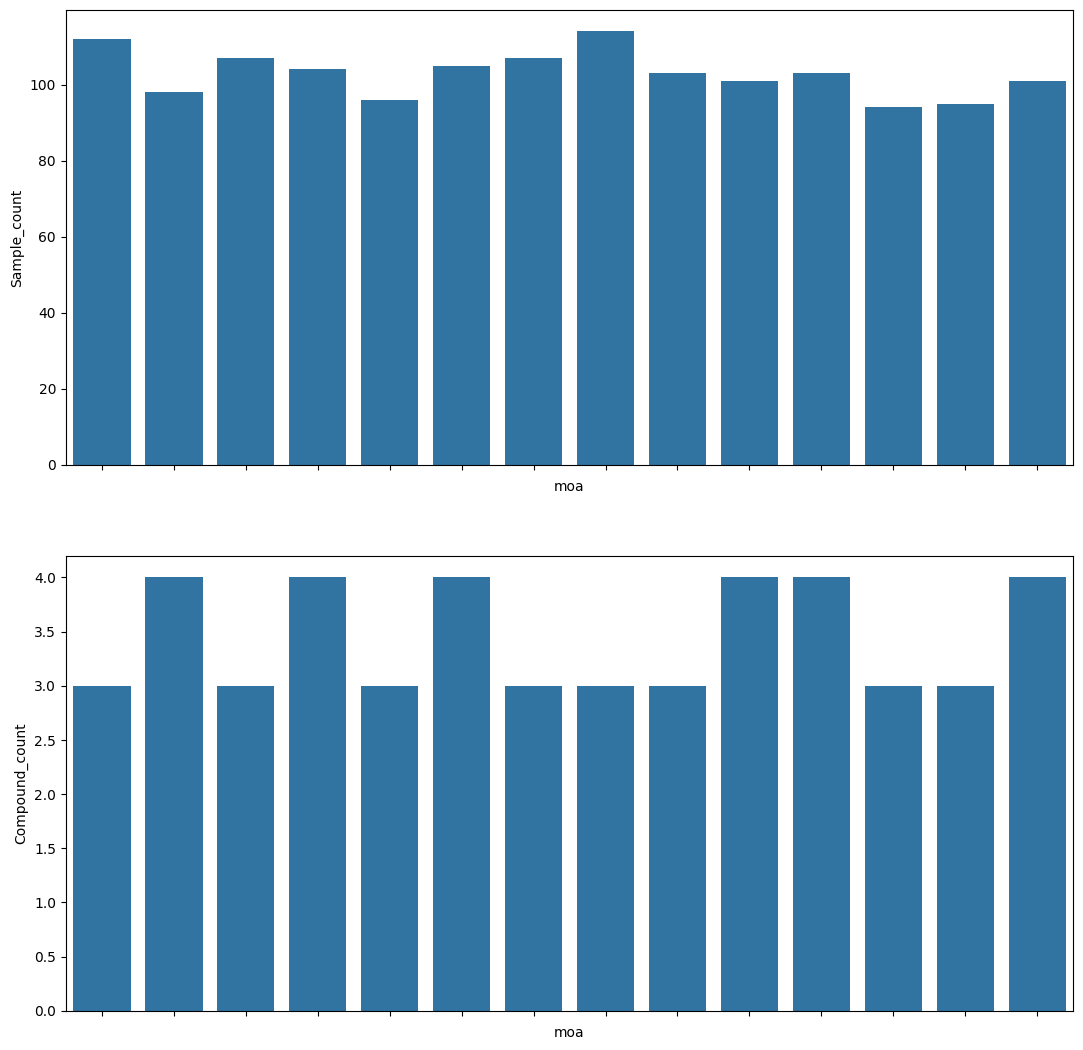

In [167]:
pdt.moa_distribution(metadata_trt_balance_moa)

### ii) balance target

In [239]:
metadata_trt_balance_target = (metadata_trt.filter(pl.col("Metadata_Source").str.contains("_7$") != True)
.with_columns(pl.col("Metadata_InChIKey").count().over("Metadata_InChIKey").alias("replicate"))
.filter((pl.col("moa").str.contains("\|") != True) &
        (pl.col("replicate").is_between(20, 50)) &
        (pl.col("Metadata_Source").n_unique().over("Metadata_InChIKey") == 
          pl.col("Metadata_Source").n_unique()))
 .with_columns(pl.col("Metadata_InChIKey").n_unique().over("target").alias("compound_per_target"),
               pl.col("Metadata_InChIKey").count().over("target").alias("replicates_per_target"))
 .filter(pl.col("compound_per_target") == 2,
         pl.col("replicates_per_target") > 60))

In [240]:
metadata_trt_balance_target = (metadata_trt_balance_target.filter(pl.col("replicates_per_target") < 70)
.vstack(constrain_comp_per_source(metadata_trt_balance_target.filter(pl.col("replicates_per_target") >= 70),
                                  min_rep=1, max_rep=5)))

metadata_trt_balance_target = (metadata_trt_balance_target
.with_columns(pl.col("Metadata_InChIKey").count().over("target").alias("replicates_per_target"))
.filter(pl.col("replicates_per_target") > 60))

### ii) Add DMSO back

In [244]:
DMSO_moa = constrain_comp_per_source(metadata.filter(pl.col("pert_iname") == "DMSO",
                                                pl.col("Metadata_Source").str.contains("_7$") != True), 
                                    min_rep=1, max_rep=14)
DMSO_target = constrain_comp_per_source(metadata.filter(pl.col("pert_iname") == "DMSO",
                                                pl.col("Metadata_Source").str.contains("_7$") != True), 
                                    min_rep=1, max_rep=9)

In [245]:
metadata_balance_moa = (metadata_trt_balance_moa.select(
    pl.all().exclude(["replicate", "compound_per_moa", "replicates_per_moa"])).vstack(DMSO_moa))

In [246]:
metadata_balance_target = (metadata_trt_balance_target.select(
    pl.all().exclude(["replicate", "compound_per_target", "replicates_per_target"])).vstack(DMSO_target))

## c) Assign a unique ID and remove metadata from features. Load into CSV file.

In [253]:
def write_load_csv(metadata=metadata, features=features, name="filtered"):
    try:
        features_df = pd.read_csv("target2_"+name+"_features", index_col="ID")
        metadata_df = pd.read_csv("target2_"+name+"_metadata", index_col="ID")
    except:
        metadata = (metadata.sort(["Metadata_JCP2022", "Metadata_Source", "Metadata_Plate", "Metadata_Well"]).
         with_columns(pl.arange(0,len(metadata)).alias("ID")))
        
        features = features.join(metadata.select(["Metadata_JCP2022", "Metadata_Source", 
                                                  "Metadata_Plate", "Metadata_Well", "ID"]).lazy(),
                      on=["Metadata_JCP2022", "Metadata_Source", "Metadata_Plate", "Metadata_Well"],
                      how="inner")
        
        features = features.sort(["Metadata_JCP2022", "Metadata_Source", "Metadata_Plate", "Metadata_Well"])
        
        metadata_df = metadata.to_pandas().set_index(keys="ID")
        features_df = features.collect().to_pandas().set_index(keys="ID")
        
        features_df = features_df.drop(["Metadata_JCP2022", 
                                        "Metadata_Source", "Metadata_Plate", "Metadata_Well"], axis=1)
        
        features_df.to_csv("target2_"+name+"_features")
        metadata_df.to_csv("target2_"+name+"_metadata")

    return features_df, metadata_df

features_df, metadata_df = write_load_csv(metadata_balance_moa, features, name="eq_moa")
#features_df, metadata_df = write_load_csv(metadata_balance_target, features, name="eq_target")

# 2) Data Processing

## a) removing features containing NaN values or np.inf values

In [254]:
nan_col = features_df.columns[features_df.isna().sum(axis=0) > 0]
nan_col, len(nan_col)

(Index([], dtype='object'), 0)

In [255]:
inf_col = features_df.columns[(features_df == np.inf).sum(axis=0) > 0]
inf_col, len(inf_col)

(Index(['Cells_AreaShape_FormFactor'], dtype='object'), 1)

In [256]:
features_df = features_df[features_df.columns[(features_df.isna().sum(axis=0) == 0) & 
                                            ((features_df == np.inf).sum(axis=0) == 0)]]

## b) Removing DMSO

In [54]:
# metadata_df_trt = metadata_df.iloc[metadata_df.index[metadata_df["pert_iname"] != "DMSO"],:]
# features_df_trt = features_df.iloc[metadata_df.index[metadata_df["pert_iname"] != "DMSO"],:]

## c) Encoding moa

In [257]:
metadata_df = metadata_df.assign(moa_id=LabelEncoder().fit_transform(metadata_df["moa"]))#"moa_reduced"]))

## d) Features selection
This website: ["Are you dropping too many correlated features?"](https://towardsdatascience.com/are-you-dropping-too-many-correlated-features-d1c96654abe6)
Is a very good reference. In the filtering done here, we might drop too many values. It has been used to create features_engineering package that I wrote.


In [47]:
features_remover = features_drop_corr(0.95)

In [48]:
features_remover.fit(features_df_trt)

In [49]:
features_df_trt_clean = features_remover.transform(features_df_trt)

## e) scaling of the features
2 ideas to do so: 
1. Use StandardScaler() as usual.
2. Removing mean and variance while grouping on sources anf then StandardScale again.
### Warning: Data Leakage!
* Do not scale the data, while the training set vs test set has not been performed. This would lead to use mean or std from the test set within the training set and therefore might lead to overestimation of the model quality.
* Here the goal of this section is just to see 2 ways of scaling the data. 

In [22]:
features_df_trt_scaled = StandardScaler().fit_transform(features_df_trt)

In [23]:
features_df_trt_scaled_source = features_df_trt.groupby(metadata_df_trt["Metadata_Source"]).transform(
    lambda x: scale(x))

# 3) Dimension reduction

In [24]:
model_pca_10= PCA(n_components=10)
model_tsne = TSNE(n_components=2)

features_df_trt_tsne_scaled = model_tsne.fit_transform(
    model_pca_10.fit_transform(features_df_trt_scaled))
features_df_trt_tsne_scaled_source = model_tsne.fit_transform(
    model_pca_10.fit_transform(features_df_trt_scaled_source))

Text(0.5, 1.0, 'Scale on sources')

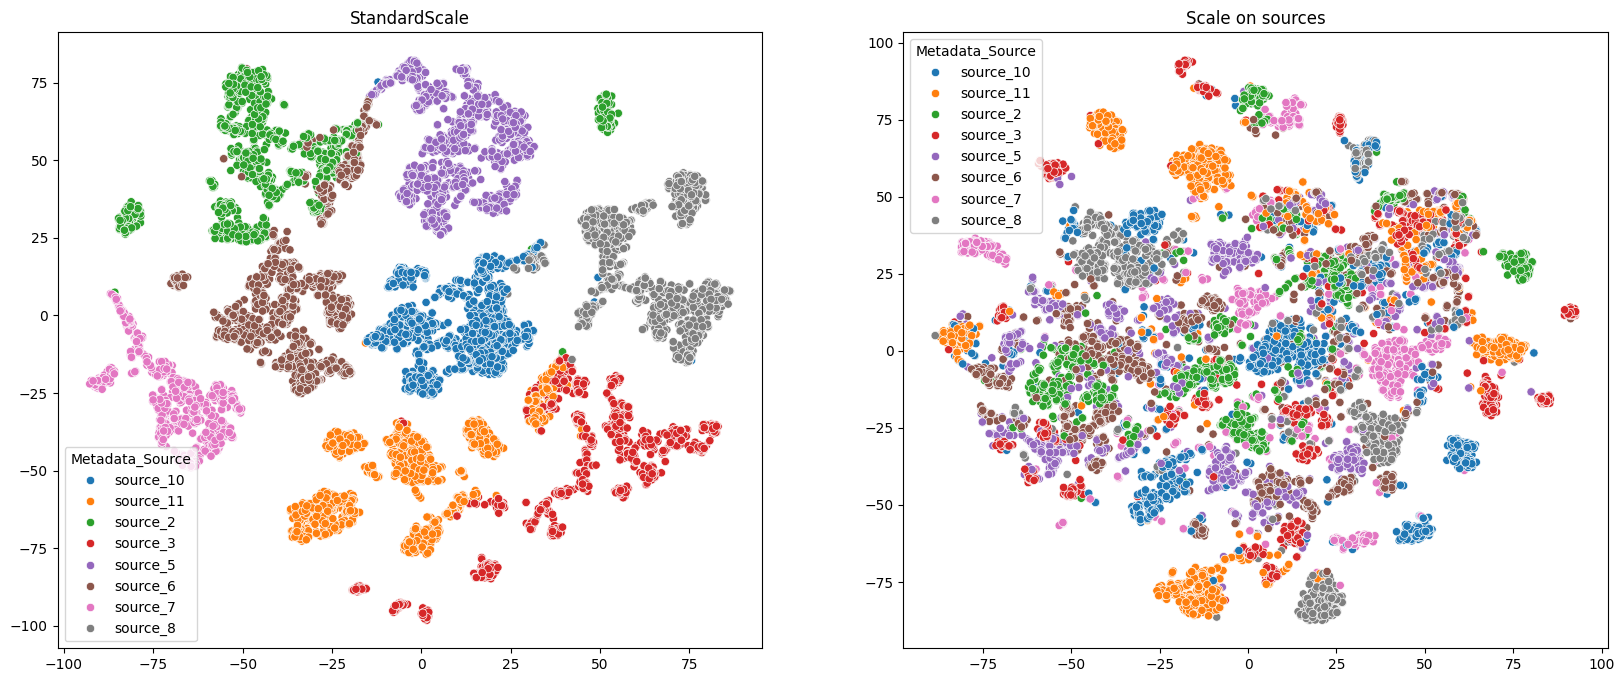

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.scatterplot(x=features_df_trt_tsne_scaled[:,0],
                y=features_df_trt_tsne_scaled[:,1],
                hue=metadata_df_trt["Metadata_Source"],
                ax=axes[0])
axes[0].set_title("StandardScale")

sns.scatterplot(x=features_df_trt_tsne_scaled_source[:,0],
                y=features_df_trt_tsne_scaled_source[:,1],
                hue=metadata_df_trt["Metadata_Source"],
                ax=axes[1])
axes[1].set_title("Scale on sources")

In [26]:
model_umap = umap.UMAP()
features_df_trt_umap_scaled = model_umap.fit_transform(features_df_trt_scaled)
features_df_trt_umap_scaled_source = model_umap.fit_transform(features_df_trt_scaled_source)

Text(0.5, 1.0, 'Scale on sources')

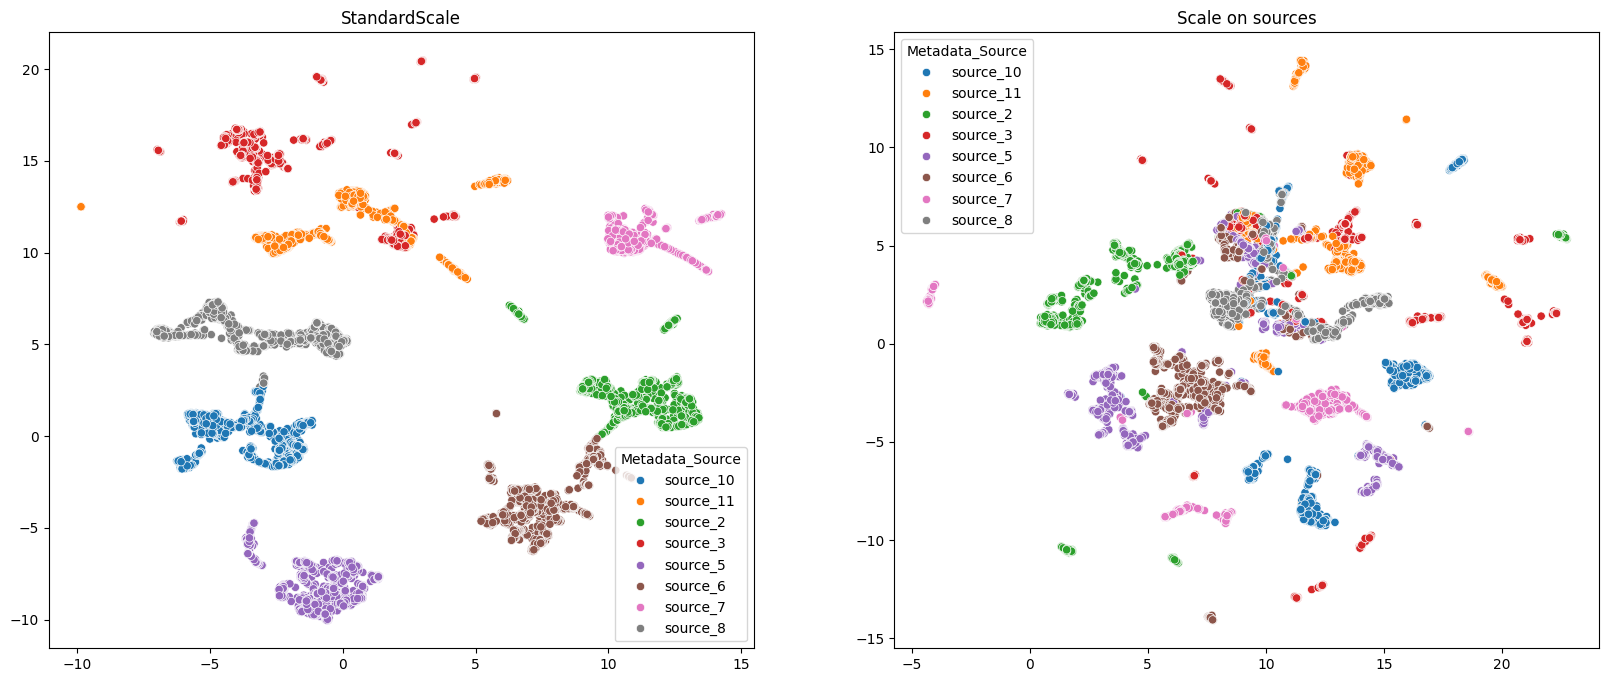

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.scatterplot(x=features_df_trt_umap_scaled[:,0],
                y=features_df_trt_umap_scaled[:,1],
                hue=metadata_df_trt["Metadata_Source"],
                ax=axes[0])
axes[0].set_title("StandardScale")

sns.scatterplot(x=features_df_trt_umap_scaled_source[:,0],
                y=features_df_trt_umap_scaled_source[:,1],
                hue=metadata_df_trt["Metadata_Source"],
                ax=axes[1])
axes[1].set_title("Scale on sources")

Text(0.5, 1.0, 'Scale on sources')

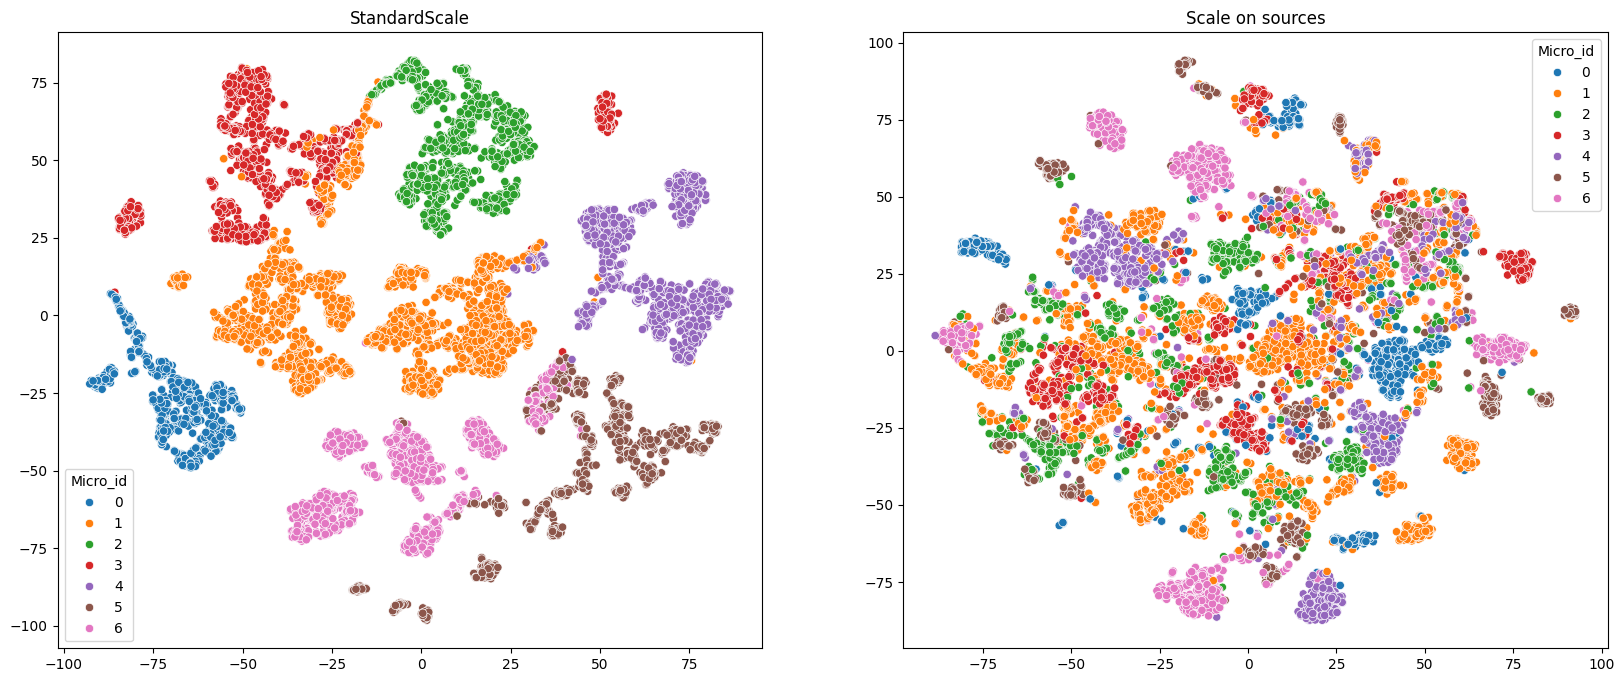

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.scatterplot(x=features_df_trt_tsne_scaled[:,0],
                y=features_df_trt_tsne_scaled[:,1],
                hue=metadata_df_trt["Micro_id"],
                ax=axes[0],
                palette="tab10")
axes[0].set_title("StandardScale")

sns.scatterplot(x=features_df_trt_tsne_scaled_source[:,0],
                y=features_df_trt_tsne_scaled_source[:,1],
                hue=metadata_df_trt["Micro_id"],
                ax=axes[1],
                palette="tab10")
axes[1].set_title("Scale on sources")

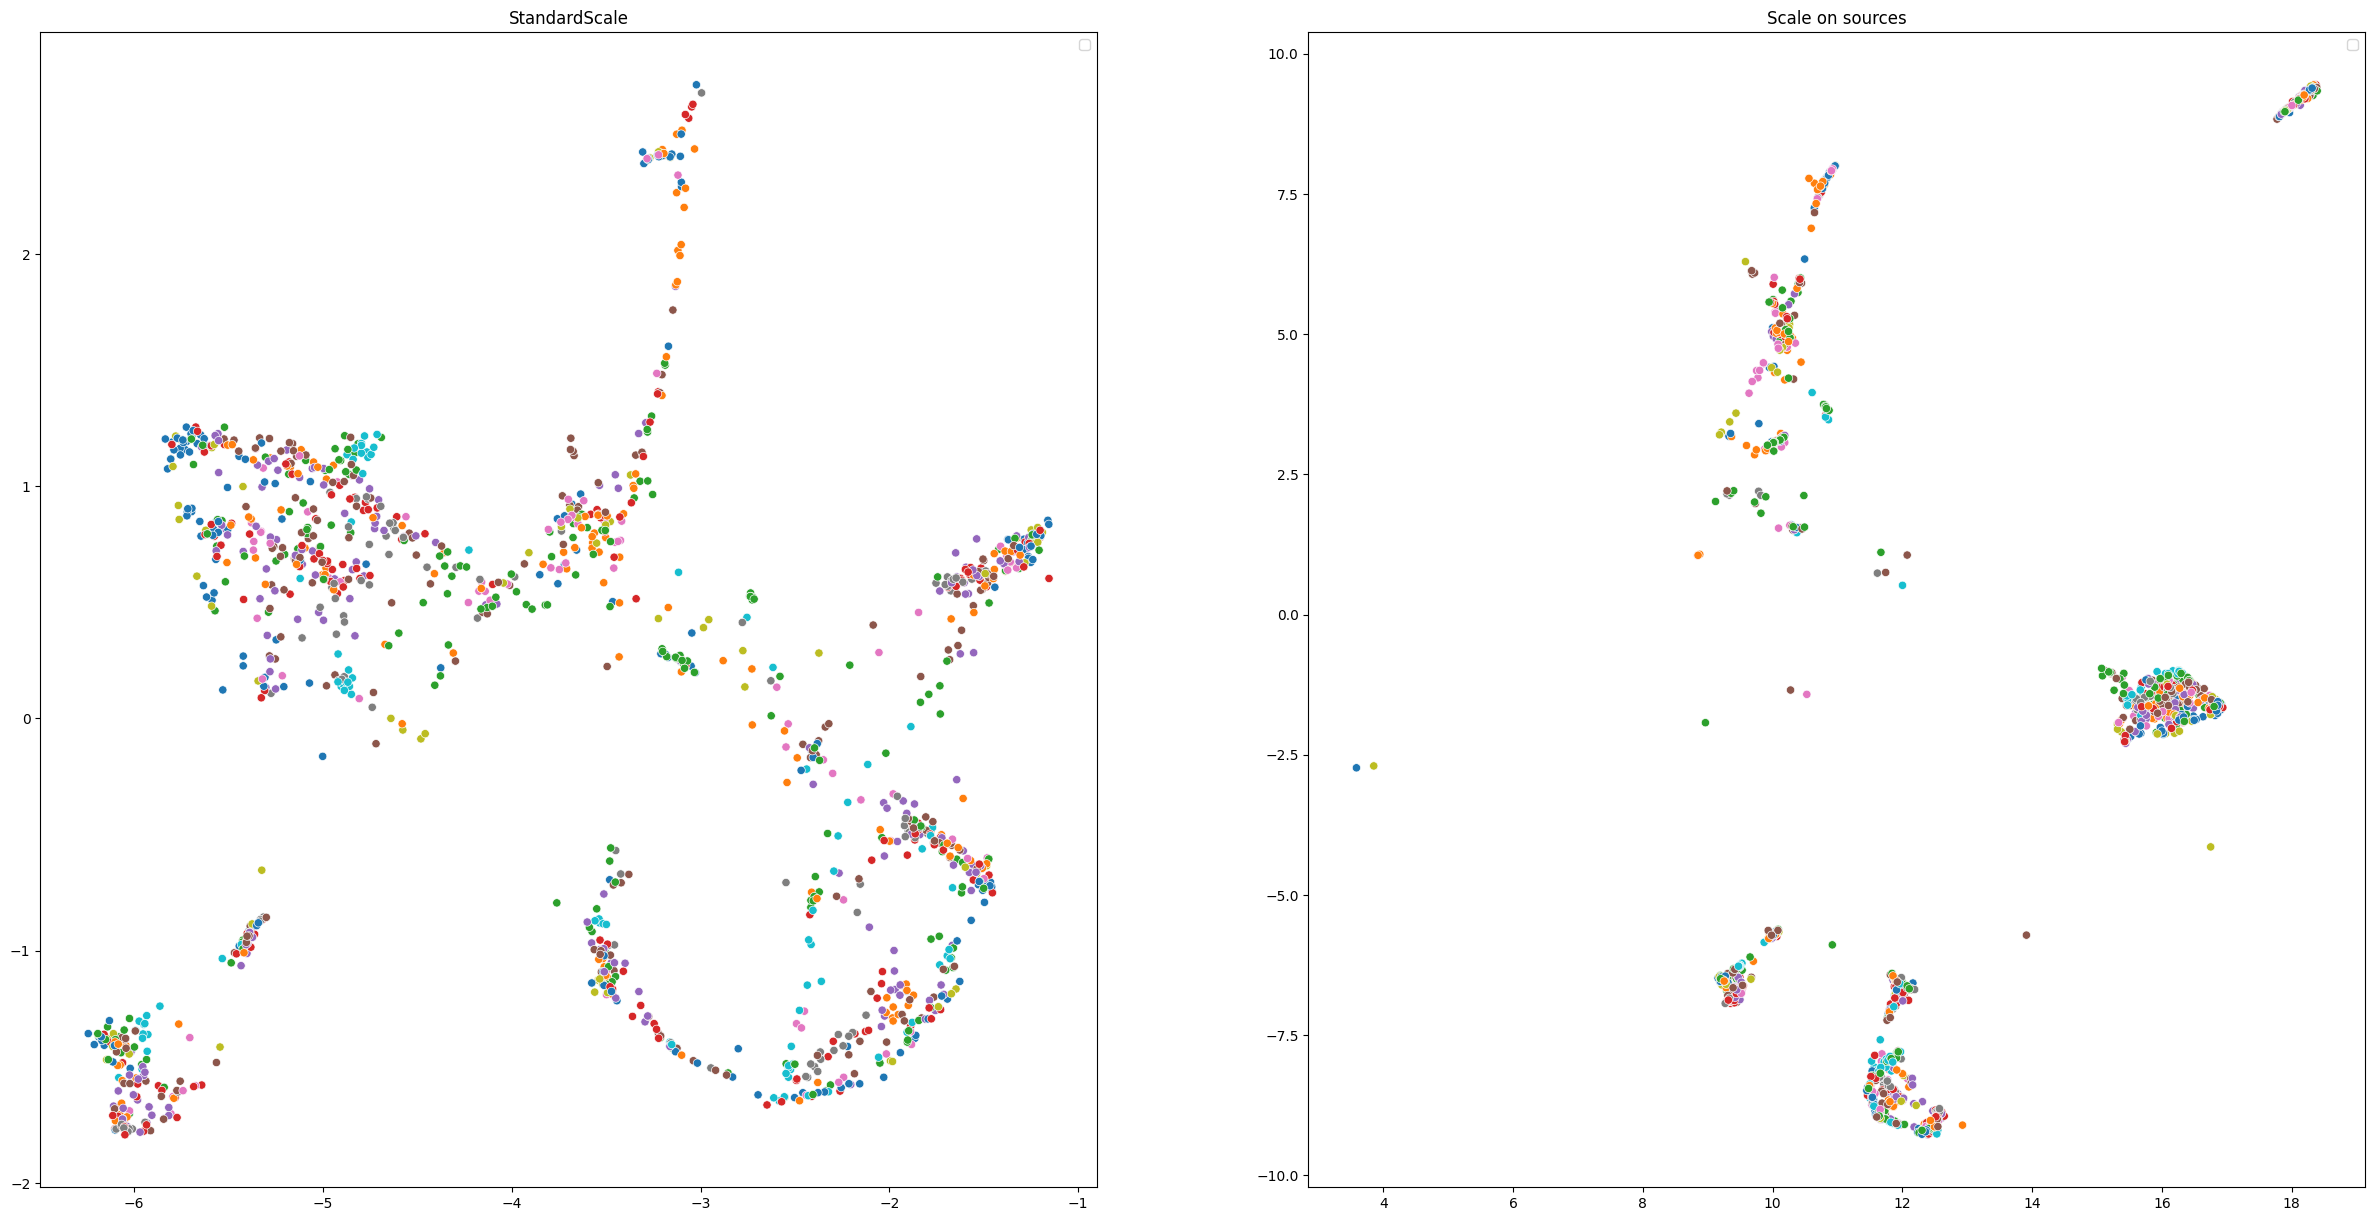

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
sns.scatterplot(x=features_df_trt_umap_scaled[metadata_df_trt["Metadata_Source"].str.contains("10"),0],
                y=features_df_trt_umap_scaled[metadata_df_trt["Metadata_Source"].str.contains("10"),1],
                hue=metadata_df_trt[metadata_df_trt["Metadata_Source"].str.contains("10")]["Metadata_Well"].str.slice(0,1),
                ax=axes[0],
                palette="tab10")
axes[0].set_title("StandardScale")
axes[0].legend("")

sns.scatterplot(x=features_df_trt_umap_scaled_source[metadata_df_trt["Metadata_Source"].str.contains("10"),0],
                y=features_df_trt_umap_scaled_source[metadata_df_trt["Metadata_Source"].str.contains("10"),1],
                hue=metadata_df_trt[metadata_df_trt["Metadata_Source"].str.contains("10")]["Metadata_Well"].str.slice(0,1),
                ax=axes[1],
                palette="tab10")
axes[1].set_title("Scale on sources")
axes[1].legend("")

In [30]:
model_pca_10= PCA(n_components=10)
model_tsne = TSNE(n_components=2)

features_df_trt_tsne = model_tsne.fit_transform(
    model_pca_10.fit_transform(features_df_trt))


model_umap = umap.UMAP()
features_df_trt_umap = model_umap.fit_transform(features_df_trt)

Text(0.5, 1.0, 'UMAP not scaled')

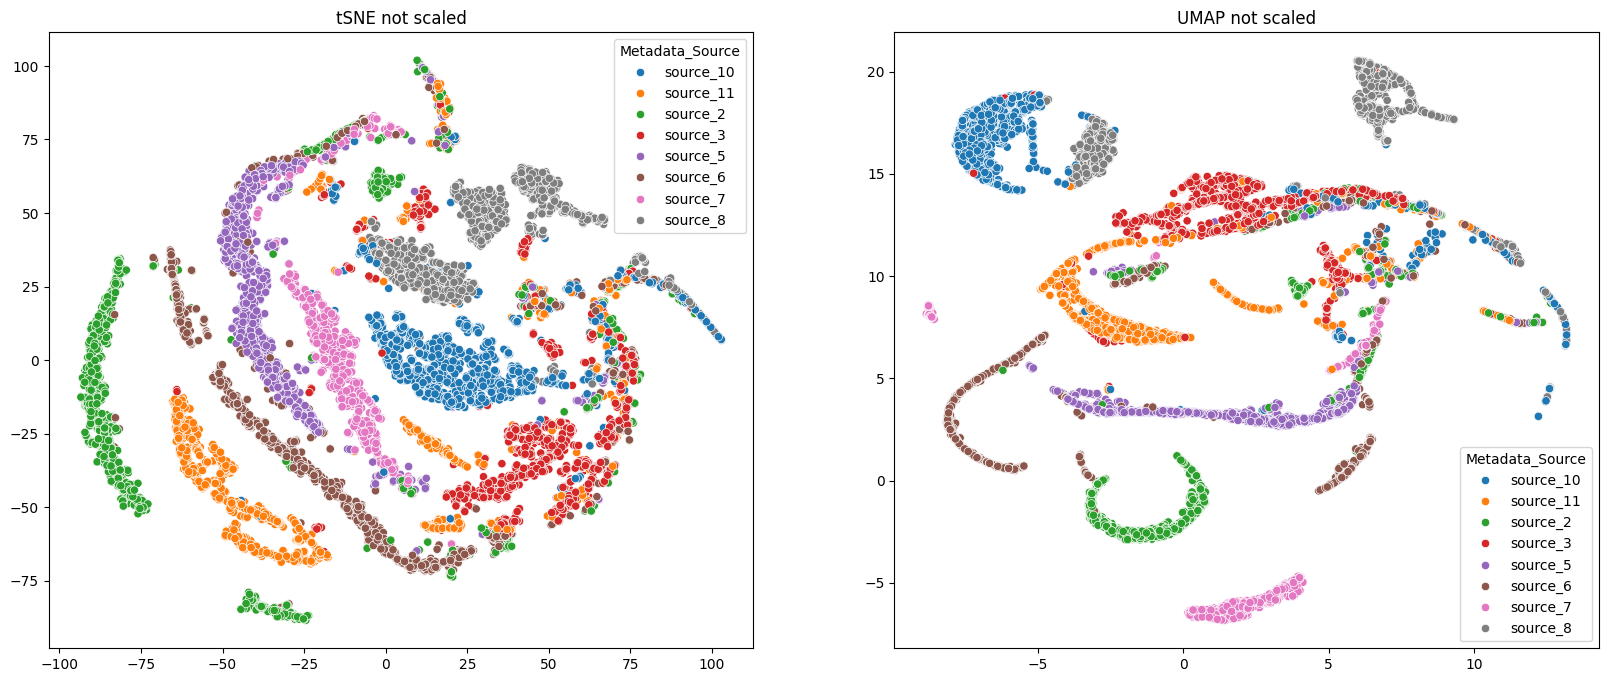

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.scatterplot(x=features_df_trt_tsne[:,0],
                y=features_df_trt_tsne[:,1],
                hue=metadata_df_trt["Metadata_Source"],
                ax=axes[0],
                palette="tab10")
axes[0].set_title("tSNE not scaled")

sns.scatterplot(x=features_df_trt_umap[:,0],
                y=features_df_trt_umap[:,1],
                hue=metadata_df_trt["Metadata_Source"],
                ax=axes[1],
                palette="tab10")
axes[1].set_title("UMAP not scaled")

# 4) Train, test Split using kfold crossvalidation

StratifiedKFold is interesting because it allows to keep a certain balance with class sample. Important as moa as an average of 30-40 samples and other may have 80 and up 300 samples. 

GroupStratifiedKFold: 
Even more intersting: as there is a bias on the Source, Using GroupStratifiedKfold allows:
1. Balance of the class
2. Ensure that a source cannot be used twice in the training and test set.
    * This could ensure that the learning is on the features of the moa itself and not necessarily on the ones from sources. 

# 5) Classifier
## a) Fine tuning by hand
### i) Random Forest

In [130]:
def expanded_score(y_true, y_score, labels):
    label_map = set(labels.tolist())| set(y_true.tolist())
    label_map = {k: i for i, k in enumerate(label_map)}
    y_score_expanded = np.zeros((y_score.shape[0], len(label_map)), dtype=y_score.dtype)
    for i, c in enumerate(labels):
        y_score_expanded[:, label_map[c]] = y_score[:, i]
    return y_score_expanded, np.array(list(label_map.keys()))


def eval_classifier(feat_table, metadata, n_splits, seed, 
                    classifier,
                    classifier_params,
                    splitter_method,
                    drop_corr=True, # True, False
                    scaler=None, #None, 'group', 'standard'
                    rev_order=False,
                    roc_per_class=False, 
                    group="Metadata_Source"): # True, False  
    
    y_target, groups =  metadata["moa_id"], metadata[group]
    
    # Initialize the Classifier
    classifier = classifier(**classifier_params)
    
    # Initialize Stratified K-Fold cross-validator
    splitter = splitter_method(n_splits=n_splits, shuffle=True, random_state=seed)

    # Build Pipeline
    pipe_list = []
    if drop_corr == True:
        if cp.cuda.is_available():
            pipe_list.append(('drop_corr', features_drop_corr_gpu()))
        else:
            pipe_list.append(('drop_corr', features_drop_corr()))
    if scaler is not None:
        if scaler == 'group':
            pipe_list.append(('scaler', StandardScaler_group(groups)))
        elif scaler == 'standard':
            pipe_list.append(('scaler', StandardScaler_pandas()))

    if rev_order == True:
        pipe_list = pipe_list[::-1]

    pipe_list.append(('classifier', classifier))
    
    pipe = Pipeline(pipe_list)
    
    # Lists to store precision-recall auc score, train and test accuracy for each fold
    train_auc_fold = []
    test_auc_fold = []
    
    n_class = np.unique(y_target).shape[0]
    keep_trac_test_error = np.zeros((n_class, n_class))

    # Perform stratified k-fold cross-validation

    for train_index, test_index in tqdm(splitter.split(feat_table, y_target, groups)):
        X_train, X_test = feat_table.loc[train_index], feat_table.loc[test_index]
        y_train, y_test = y_target.loc[train_index], y_target.loc[test_index]

        # Fit the classifier on training data
        pipe.fit(X_train, y_train)
        
        # Predict probabilities of the positive class for train and test data
        y_train_scores = pipe.predict_proba(X_train)  # Train set
        y_test_scores = pipe.predict_proba(X_test)    # Test set
        
        y_train_score_expanded, train_label_expanded = expanded_score(y_train, y_train_scores, pipe.classes_)
        y_test_score_expanded, test_label_expanded = expanded_score(y_test, y_test_scores, pipe.classes_)

        #print(y_train, y_test)
        # Compute ROC_AUC for train and test set
        
        if roc_per_class == False: 
            average = "macro"
        else: 
            average = None
            for i, j in zip(y_test.values, np.argmax(y_test_score_expanded, axis=1)):
                keep_trac_test_error[i][j] += 1  

           
        train_auc = roc_auc_score(y_train, y_train_score_expanded,
                                  multi_class="ovr",
                                  average=average,
                                  labels=train_label_expanded)

        return y_test, y_test_score_expanded
        test_auc = roc_auc_score(y_test, y_test_score_expanded,
                                 multi_class="ovr",
                                 average=average,
                                 labels=test_label_expanded)
        
        if roc_per_class == False:
            print(train_auc, test_auc)
        # Append train and test accuracy, train and test AUC score to respective lists
        train_auc_fold.append(train_auc)
        test_auc_fold.append(test_auc)
    
    # Average metrics across all folds
    mean_train_auc = np.mean(train_auc_fold)
    mean_test_auc = np.mean(test_auc_fold)
    
    if roc_per_class == True:
        train_auc_fold = np.array(train_auc_fold)
        test_auc_fold = np.array(test_auc_fold)
        fig, axes = plt.subplots(4, 1, figsize=(20, 20))

        hue = ['enriched' if (x in np.unique(metadata["moa_id"][metadata["moa"].str.contains("\|")].values))
            else 'normal' for x in np.arange(n_class)]
        
        # palette = ['red' if (x in np.unique(metadata["moa_id"][metadata["moa"].str.contains("\|")].values))
        #     else 'blue' for x in np.arange(np.unique(metadata["moa_id"]).shape[0])]
        
        sns.barplot(x=np.arange(train_auc_fold.shape[1]),
                    y=np.mean(train_auc_fold, axis=0),
                    hue=hue,
                    ax=axes[0])
        axes[0].tick_params(axis='x', rotation=90, labelsize='xx-small')
        axes[0].set_title("Train set ROC-AUC per class")
        axes[0].set_ylabel("ROC-AUC")
        axes[0].set_xlabel("Class")

        sns.barplot(x=np.arange(test_auc_fold.shape[1]),
                    y=np.mean(test_auc_fold, axis=0),
                    hue=hue,
                    ax=axes[1])
        axes[1].tick_params(axis='x', rotation=90, labelsize='xx-small')
        axes[1].set_title("Test set ROC-AUC per class")
        axes[1].set_ylabel("ROC-AUC")
        axes[1].set_xlabel("Class")

        sns.barplot(x=np.arange(test_auc_fold.shape[1]),
                    y=np.bincount(y_target.values),
                    hue=hue,
                    ax=axes[2])
        axes[2].tick_params(axis='x', rotation=90, labelsize='xx-small')
        axes[2].set_title("Sample count per class")
        axes[2].set_ylabel("Sample Count")
        axes[2].set_xlabel("Class")
        
        sns.scatterplot(x=np.bincount(y_target.values),
                        y=np.mean(test_auc_fold, axis=0),
                        hue=hue,
                        ax=axes[3])
        axes[3].set_title("Test set ROC-AUC vs Sample count")
        axes[3].set_ylabel("ROC-AUC")
        axes[3].set_xlabel("Sample_count")

        
        fig, ax = plt.subplots(1, 1, figsize=(20, 15))
        keep_trac_test_error[np.diag(np.ones(n_class).astype(bool))] = np.zeros(n_class)
        keep_trac_test_error = keep_trac_test_error / np.sum(keep_trac_test_error, axis=1).reshape(-1,1)
        sns.heatmap(keep_trac_test_error,
                   ax=ax,
                   cbar=False)
        ax.set_title("Count per wrong class for each true class")
        ax.set_ylabel("True class")
        ax.set_xlabel("Wrong class")
        most_frequent_wrong = np.argmax(keep_trac_test_error, axis=1)
        for i in range(n_class):
            ax.add_patch(Rectangle((most_frequent_wrong[i], i),1,1, fill=False, edgecolor='g', lw=1.5))
        
        return test_auc_fold, most_frequent_wrong

    
    print(f"Mean Train ROC-AUC Score: {mean_train_auc:.4f}")
    print(f"Mean Test ROC-AUC Score: {mean_test_auc:.4f}")


In [57]:
features_df_trt = features_df_trt.sort_index().reset_index(drop=True)
metadata_df_trt = metadata_df_trt.sort_index().reset_index()

In [ ]:
class StratifiedGroupKFold_custom:
    def __init__(self, n_splits=5, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
        
    def split(self, X, y, groups): 
        moa_to_kfold = []
        moa_to_pert = {k: [] for k in y.unique()}
        for l in list(zip(y, groups)):
            moa_to_pert[l[0]] += [l[1]]
        for k in list(moa_to_pert.keys()):
            moa_to_pert[k] = list(set(moa_to_pert[k]))
            if len(moa_to_pert[k]) == 1:
                moa_to_pert.pop(k)
                moa_to_kfold.append(k)
        
        
        np.random.seed(self.random_state) 
        arr_picks = []
        for k in list(moa_to_pert.keys()):
            picks = np.arange(len(moa_to_pert[k]))
            remaining_picks = self.n_splits - len(picks)
            if remaining_picks > 0:
                picks = np.hstack((picks, np.random.choice(picks, size=remaining_picks)))
            else: 
                picks = np.random.choice(picks, size=self.n_splits)
            np.random.shuffle(picks)
            arr_picks.append(picks.tolist())
        arr_picks = np.array(arr_picks)
        
        fold_index = [] 
        for split in range(self.n_splits):
            train_index, test_index = [], []
            for moa, pert in zip(list(moa_to_pert.keys()), (arr_picks[:, split])):
                test_index += list(groups.index[groups == (moa_to_pert[moa][pert])])
                train_index += list(groups.index[groups.isin(set(moa_to_pert[moa]) - 
                                                             set(moa_to_pert[moa][pert].split(" ")))])
            fold_index.append((train_index, test_index))
            
        index_to_kfold = np.array(y.index[(y.isin(moa_to_kfold))])
        kfold_splitter = StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                         random_state=self.random_state)
        for i, (train_index, test_index) in enumerate(kfold_splitter.split(X.loc[index_to_kfold], 
                                                                           y.loc[index_to_kfold])):
            
            np.random.seed(self.random_state)
            fold_index[i] = (np.random.permutation(fold_index[i][0] + index_to_kfold[train_index].tolist()), 
                             np.random.permutation(fold_index[i][1] + index_to_kfold[test_index].tolist()))

        return fold_index

In [260]:

np.random.randint(1, 5, size=(14, 5))

array([[3, 1, 2, 1, 3],
       [4, 3, 3, 2, 4],
       [1, 2, 3, 2, 4],
       [1, 3, 3, 3, 2],
       [2, 2, 4, 4, 3],
       [3, 4, 1, 3, 3],
       [1, 4, 3, 3, 1],
       [3, 3, 4, 4, 1],
       [1, 2, 4, 4, 3],
       [1, 4, 4, 1, 3],
       [1, 1, 2, 2, 2],
       [4, 1, 3, 2, 4],
       [4, 3, 1, 2, 2],
       [2, 4, 1, 1, 1]])

In [258]:
moa_to_pert = {k: [] for k in metadata_df["moa_id"].unique()}
for l in list(zip(metadata_df["moa_id"], metadata_df["Metadata_InChIKey"])):
    moa_to_pert[l[0]] += [l[1]]
for k in moa_to_pert.keys():
    moa_to_pert[k] = list(set(moa_to_pert[k]))
moa_to_pert

{12: ['ZQPXNYLXYNRFNP-UHFFFAOYSA-N',
  'ALOBUEHUHMBRLE-UHFFFAOYSA-N',
  'NUKYPUAOHBNCPY-UHFFFAOYSA-N'],
 4: ['BLVQHYHDYFTPDV-UHFFFAOYSA-N',
  'FERIUCNNQQJTOY-UHFFFAOYSA-N',
  'SOOPLNPQGWJZHY-UHFFFAOYSA-N',
  'JHSXDAWGLCZYSM-UHFFFAOYSA-N'],
 6: ['PBBRWFOVCUAONR-UHFFFAOYSA-N',
  'DMWVGXGXHPOEPT-UHFFFAOYSA-N',
  'NBTNHSGBRGTFJS-UHFFFAOYSA-N',
  'ZVPDNRVYHLRXLX-UHFFFAOYSA-N'],
 1: ['MAASHDQFQDDECQ-UHFFFAOYSA-N',
  'DUKQPWDVIZDABV-UHFFFAOYSA-N',
  'DXZRBHUCOHBAHP-UHFFFAOYSA-N'],
 14: ['NUIKTBLZSPQGCP-UHFFFAOYSA-N',
  'FMYGNANMYYHBSU-UHFFFAOYSA-N',
  'FHPOTBQOUBMMCI-UHFFFAOYSA-N',
  'XRVDGNKRPOAQTN-UHFFFAOYSA-N'],
 13: ['KXDROGADUISDGY-UHFFFAOYSA-N',
  'FNYLWPVRPXGIIP-UHFFFAOYSA-N',
  'XSDQTOBWRPYKKA-UHFFFAOYSA-N'],
 10: ['JUUFBMODXQKSTD-UHFFFAOYSA-N',
  'FYIBXBFDXNPBSF-UHFFFAOYSA-N',
  'UQNAFPHGVPVTAL-UHFFFAOYSA-N'],
 5: ['WSMQUUGTQYPVPD-UHFFFAOYSA-N',
  'HGMSUJCQIUFZBJ-UHFFFAOYSA-N',
  'ZRALSGWEFCBTJO-UHFFFAOYSA-N',
  'RVAQIUULWULRNW-UHFFFAOYSA-N'],
 7: ['VCKUSRYTPJJLNI-UHFFFAOYSA-N',
  'H

In [165]:
splitter = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=5)
for train_index, test_index in splitter.split(features_df_trt, metadata_df_trt["moa_id"], metadata_df_trt["Metadata_InChIKey"]):
    train_test, test_test = metadata_df_trt["moa_id"].loc[train_index], metadata_df_trt["moa_id"].loc[test_index]
    print(len(set(train_test.tolist())), len(set(test_test.tolist())))

13 12
14 10
14 10


In [131]:
n_splits=5
seed = 50

classifier = RandomForestClassifier

classifier_params = {"n_estimators": 100,
                     "max_depth": 20,
                     "min_samples_split": 40,
                     "min_samples_leaf": 25,
                     "min_weight_fraction_leaf": 0.0, 
                     "max_leaf_nodes": None,
                     "random_state": 42,
                     "n_jobs": -1} 

splitter_method = StratifiedGroupKFold#StratifiedKFold  #or StratifiedGroupKFold

# test_auc_fold, most_frequent_wrong = eval_classifier(features_df_trt, metadata_df_trt, n_splits, seed, 
y_test, y_test_score_expanded = eval_classifier(features_df_trt, metadata_df_trt, n_splits, seed,
                classifier,
                classifier_params,
                splitter_method, 
                drop_corr=True, # True, False
                scaler=None, #None, 'group', 'standard': Do NOT use group with StratifiedGroupKFold
                rev_order=False,
                roc_per_class=False,
                group="Metadata_InChIKey") # True, False  

0it [00:03, ?it/s]


In [147]:
len(y_test.unique())

8

In [146]:
y_test.shape

(282,)

In [145]:
y_test_score_expanded.shape

(282, 14)

In [137]:
(y_test, y_test_score_expanded, multi_class="ovr")

ValueError: Number of classes in y_true not equal to the number of columns in 'y_score'

In [62]:
mask = (np.mean(test_auc_fold, axis=0) < 0.7)

map_id_moa = (metadata_df_trt.loc[:,["moa_id", "moa"]].sort_values(by="moa_id").drop_duplicates()
              .groupby("moa_id")["moa"].apply(list))

true_moa_vs_wrong_moa = pd.concat([map_id_moa.iloc[np.nonzero(mask)].to_frame().reset_index().add_suffix("_True"), 
                                   map_id_moa.iloc[most_frequent_wrong[mask]].to_frame().reset_index().add_suffix("_Wrong")], 
                                  axis=1)
true_moa_vs_wrong_moa

,moa_id_True,moa_True,moa_id_Wrong,moa_Wrong
0,8,[cyclooxygenase inhibitor],7,[adrenergic receptor antagonist]
1,11,[potassium channel blocker],8,[cyclooxygenase inhibitor]


#### Random Forest Fine Tuning Table

| Parameter                   | Value  | Value 1 | Value 2 | Value 3 | Value 4 | Value 5 | Value 6 |
|-----------------------------|--------|---------|---------|---------|---------|---------|---------|
| **n_estimators**            | **100**| **50**  | **200** | **500** | **1000**|  100    | **500** |
| **max_depth**               | **None**| None    | None    | None    | None    | None    | None    |
| **min_samples_split**       | **2**  | 2       | 2       | 2       | 2       | 2       | 2       |
| **min_samples_leaf**        | **1**  | 1       | 1       | 1       | 1       | 1       | 1       |
| **min_weight_fraction_leaf**| **0.0**| 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **class_weight**            | **None**| None    | None    | None    | None    | **balanced** | **balanced_subsample** |
| **max_leaf_nodes**          | **None**| None    | None    | None    | None    | None    | None    |
| **random_state**            | **42** | 42      | 42      | 42      | 42      | 42      | 42      |
| **n_jobs**                  | **-1** | -1      | -1      | -1      | -1      | -1      | -1      |
| ---                        | ---    | ---     | ---     | ---     | ---     | ---     | ---     |
| **time_it**                 | 8.30   | 11.00   | 12.90   | 19.37   | 37.11   | 9.20    | 20.00   |
| **Mean Train ROC-AUC Score**| 1.0000 | 1.0000  | 1.0000  | 1.0000  | 1.0000  | 1.0000  | 1.0000  |
| **Mean Test ROC-AUC Score** | 0.7159 | 0.6901  | 0.7367  | 0.7569  | **0.7702** | 0.7130  | 0.7574  |


| Parameter                   | Value 7| Value 8 | Value 9 |Value 10 |Value 11 |Value 12 |Value 13 |
|-----------------------------|--------|---------|---------|---------|---------|---------|---------|
| **n_estimators**                | 100    | 100     | 100     | **500**     | **1000**    | **1000**    | 100     |
| **max_depth**                   | **4**  | **10**  | **20**   | **20**     | **20**   | **20**   | **20**      |
| **min_samples_split**           | 2      | 2       | 2       | 2       | 2       | 2       |  **40**     |
| **min_samples_leaf**            | 1      | 1       | 1       | 1       | 1       | 1       |  **25**     |
| **min_weight_fraction_leaf**    | 0.0    | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     | 0.0     |
| **class_weight**                | None   | None    | None    | None    | None    | None    | None    |
| **max_leaf_nodes**              | None   | None    | None    | None    | None    | None    | None    |
| **random_state**                 | 42     | 42      | 42      | 42      | 42      | 42      | 42      |
| **n_jobs**                      | -1     | -1      | -1      | -1      | -1      | -1      | -1      |
| ---                        | ---    | ---     | ---     | ---     | ---     | ---     | ---     |
| **time_it**                     | 3.10   |  4.5    |  4.71   | 7.86    |  11.53  |  8.14   |  4.17   |
| **Mean Train ROC-AUC Score**    | 0.7891 | 0.8815  | 0.9495  | 0.9752  | 0.9808  | 0.9251  | 0.9834  |
| **Mean Test ROC-AUC Score**     | 0.7277 | 0.7677  | 0.7851  | 0.7925  | 0.7938  | 0.7774  | **0.7938**|


| **Parameter**                   | **Value 14** | **Value 15** | **Value 16** | **Value 17** | **Value 18** |
|-----------------------------|--------------|--------------|--------------|--------------|--------------|
| **n_estimators**            | **500**      | **1000**     | 100          | **500**      | 100          |
| **max_depth**               | **20**       | **20**       | **20**       | **20**       | **20**       |
| **min_samples_split**       | **40**       | **40**       | **40**       | **40**       | **20**       |
| **min_samples_leaf**        | **25**       | **25**       | **25**       | **25**       | **1**        |
| **min_weight_fraction_leaf**| 0.0          | 0.0          | 0.0          | 0.0          | 0.0          |
| **class_weight**            | None         | None         | None         | None         | **balanced** |
| **max_leaf_nodes**          | None         | None         | **50**       | **75**       | None         |
| **random_state**            | **42**       | **42**       | **42**       | **42**       | **42**       |
| **n_jobs**                  | **-1**       | **-1**       | **-1**       | **-1**       | **-1**       |
| ---                        | ---          | ---          | ---          | ---          | ---          |
| **time_it**                 | 6.59         | 9.69         | 3.73         | 6.21         | 3.47         |
| **Mean Train ROC-AUC Score**| 0.9883       | 0.9890       | 0.9206       | 0.9792       | 0.9298       |
| **Mean Test ROC-AUC Score** |     0.7996   |<span style="color:blue">**0.8001** </span> | 0.7842  | 0.7999 | 0.7711  |


### ii) XGBoost

In [64]:
n_splits=5
seed = 42
splitter_method = StratifiedKFold 
classifier = XGBClassifier
classifier_params = {'device': 'cuda',
                     'objective': 'multi:softprob',#'binary:logistic', multi:softprob
                     'eval_metric': 'auc', #aucpr
                     
                     'eta': 0.1, #learning rate
                     
                     'reg_alpha': 1e-2, #L1
                     'reg_lambda': 1e-2, #L2
                     
                     'gamma': 0, #min loss reduction for split
                     'max_depth': 3,
                     'max_leaves': 0,
                     'min_child_weight': 1,
                     'n_jobs': 1, #Try 118
                     'random_state': 42,
                    
                     'subsample': 0.5,
                     'colsample_bytree': 0.5,
                     'colsample_bylevel': 0.5,
                     'colsample_bynode': 0.5,
                     'max_delta_step': None}#In case of huge imbalance. set between 1-10 is usual in case of usage

eval_classifier(features_df_trt, metadata_df_trt, n_splits, seed, 
                classifier,
                classifier_params,
                splitter_method, 
                drop_corr=True, # True, False
                scaler=None, #None, 'group', 'standard': Do NOT use group with StratifiedGroupKFold
                rev_order=False,
                roc_per_class=False) # True, False 

/home/hhakem/counterfactuals_projects/.venv/envs/counterfactuals/lib/python3.10/site-packages/sklearn/model_selection/_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
1it [00:04,  4.43s/it]

1.0 0.7886097612179261


2it [00:08,  4.44s/it]

1.0 0.8042186660623584


3it [00:13,  4.45s/it]

1.0 0.7786321636678979


4it [00:18,  4.58s/it]

0.9999983718128236 0.7745274037320424


5it [00:22,  4.52s/it]

0.9999982530676134 0.8179481383224833
Mean Train ROC-AUC Score: 1.0000
Mean Test ROC-AUC Score: 0.7928


#### XGBoost Fine tuning Table

| **Parameter**               |**Value1**|**Value2**|**Value3**|**Value4**|**Value5**|**Value6**|**Value7**|**Value8**|
|-----------------------------|--------|--------|--------|--------|--------|--------|--------|--------|
| **objective**                   | multi:softprob  | **binary:logistic** | multi:softprob | multi:softprob | multi:softprob | multi:softprob | multi:softprob | multi:softprob |
| **eval_metric**                 | auc    | auc    | **aucpr**    | auc    | auc    | auc    | auc    | auc    |
| **eta**                         | 0.01   | 0.01   | 0.01   | 0.01   | 0.01   | 0.01   | **0.1**| **0.1**   |
| **reg_alpha**                   | 0      | 0      | 0      | 0      | 0      | 0      | 0      | 0      |
| **reg_lambda**                  | 0      | 0      | 0      | 0      | 0      | 0      | 0      | 0      |
| **gamma**                       | 0      | 0      | 0      | 0      | 0      | 0      | 0      | 0      |
| **max_depth**                   | 3      | 3      | 3      | 3      | 3      | 3      | 3      | 3      |
| **max_leaves**                  | 0      | 0      | 0      | 0      | 0      | 0      | 0      | 0      |
| **min_child_weight**            | 1      | 1      | 1      | 1      | 1      | 1      | 1      | 1      |
| **subsample**                   | 1      | 1      | 1      | **0.5**| **0.5**|**0.5** |**0.5** |**0.5** |
| **colsample_bylevel**           | 1      | 1      | 1      | 1      | 1      |**0.5** |**0.5** |**0.5** |
| **colsample_bynode**            | 1      | 1      | 1      | 1      | 1      |**0.5** |**0.5** |**0.5** |
| **colsample_bytree**            | 1      | 1      | 1      | 1      | **0.5**|**0.5** |**0.5** |**0.5** |
| **max_delta_step**              | None   | None   | None   | None   | None   | None   |None    |**0.5** |
| ---                         | ---    | ---    | ---    | ---    | ---    | ---    | ---    | ---    |
| **time_it**                     | 37.20  | 37.13  | 37.13  | 35.02  | 35.02  | 39.18  | 40.72   | 40  |
| **Mean Train ROC-AUC Score**    | 0.9737 | 0.9737 | 0.9737 | 0.9882 | 0.9298 | 0.9862 | 0.9999 | 1.0000 |
| **Mean Test ROC-AUC Score**     | 0.7427 | 0.7427 | 0.7427 | 0.7427 | 0.7428 | 0.7428 |**0.7764**| 0.7664 |


| **Parameter**               | **Value9**| **Value10**| **Value11**|
|-----------------------------|-----------|-----------|-----------|
| **objective**               |multi:softprob|multi:softprob|multi:softprob|
| **eval_metric**             |auc|auc|auc|
| **eta**                     |**0.1**|**0.1**|**0.1**|
| **reg_alpha**               |   0     |   0    |**0.01**|
| **reg_lambda**              |**0.001**|**0.01**|**0.01**|
| **gamma**                   |0|0|0|
| **max_depth**               |3|3|3|
| **max_leaves**              |0|0|0|
| **min_child_weight**        |1|1|1|
| **subsample**               |**0.5**|**0.5**|**0.5**|
| **colsample_bylevel**       |**0.5**|**0.5**|**0.5**|
| **colsample_bynode**        |**0.5**|**0.5**|**0.5**|
| **colsample_bytree**        |**0.5**|**0.5**|**0.5**|
| **max_delta_step**          |**0.5**|**0.5**|**0.5**|
| ---                         |---|---|---|
| **time_it**                 |40.32|40.32|44.18|
| **Mean Train ROC-AUC Score**|0.9999|0.9999|0.9999|
| **Mean Test ROC-AUC Score** |0.7663|0.7776|0.7756|


## b) Fine tuning using Ray Tune 

In [67]:
def eval_classifier_ray_tune(config):
    subdict1 = {key: config[key] for key in ["feat_table",
                              "metadata",
                              "n_splits",
                              "seed",
                              "classifier",
                              "splitter_method",
                              "drop_corr",
                              "scaler",
                              "rev_order",
                              "balance_weight"]}
    classifier_params = {key : config[key] for key in set(config) - set(subdict1)}
    [feat_table, 
     metadata, 
     n_splits, 
     seed, 
     classifier,
     splitter_method,
     drop_corr, 
     scaler, 
     rev_order,
     balance_weight] = list(subdict1.values())
    
    y_target, groups =  metadata["moa_id"], metadata["Metadata_Source"]
    
    # Initialize the Classifier
    classifier = classifier(**classifier_params)
    
    # Initialize Stratified K-Fold cross-validator
    splitter = splitter_method(n_splits=n_splits, shuffle=True, random_state=seed)

    # Build Pipeline
    pipe_list = []
    if drop_corr == True:
        if cp.cuda.is_available():
            pipe_list.append(('drop_corr', features_drop_corr_gpu()))#features_drop_corr_gpu
        else:
            pipe_list.append(('drop_corr', features_drop_corr()))
    if scaler is not None:
        if scaler == 'group':
            pipe_list.append(('scaler', StandardScaler_group(groups)))
        elif scaler == 'standard':
            pipe_list.append(('scaler', StandardScaler_pandas()))

    if rev_order == True:
        pipe_list = pipe_list[::-1]

    pipe_list.append(('classifier', classifier))
    pipe = Pipeline(pipe_list)
    
    # Lists to store ROC_AUC score, train and test accuracy for each fold
    test_auc_fold = []
    
    # Perform stratified k-fold cross-validation
    for train_index, test_index in tqdm(splitter.split(feat_table, y_target, groups)):
        X_train, X_test = feat_table.loc[train_index], feat_table.loc[test_index]
        y_train, y_test = y_target.loc[train_index], y_target.loc[test_index]
        
        # Fit the classifier on training data
        if balance_weight == True:
            sample_weights = compute_sample_weight(
                class_weight='balanced',
                y=y_train)
            pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)
        pipe.fit(X_train, y_train)
        
        y_test_scores = pipe.predict_proba(X_test)    # Test set
        y_test_score_expanded, test_label_expanded = expanded_score(y_test, y_test_scores, pipe.classes_)

        test_auc = roc_auc_score(y_test, y_test_score_expanded,
                                 multi_class="ovr",
                                 average="macro",
                                 labels=test_label_expanded)
        
        # Append train and test accuracy, train and test AUC score to respective lists
        test_auc_fold.append(test_auc)
    
    mean_test_auc = np.mean(test_auc_fold)
    train.report({"mean_test_auc": mean_test_auc, "done": True})


In [68]:
# import os
# os.environ['TUNE_MAX_PENDING_TRIALS_PG'] = '1' 

n_splits=5
seed = 42

classifier = RandomForestClassifier
splitter_method = StratifiedKFold  #or StratifiedGroupKFold

config = {"n_estimators": tune.randint(80, 600), #100,
         "max_depth": tune.randint(10, 25), #20,
         "min_samples_split": tune.randint(1, 50), #40,
         "min_samples_leaf": tune.randint(1, 30), #25,
         # "max_leaf_nodes": None,
         "random_state": 42,
         "n_jobs": -1,
         "feat_table": features_df_trt, 
         "metadata": metadata_df_trt, 
         "n_splits": n_splits, 
         "seed": seed, 
         "classifier": classifier,
         "splitter_method": splitter_method, 
         "drop_corr": True, # True, False
         "scaler": None, #None, 'group', 'standard': Do NOT use group with StratifiedGroupKFold
         "rev_order": False,
         "balance_weight":False} 

trainable_with_resources = tune.with_resources(eval_classifier_ray_tune, resources={"cpu": 192, "gpu": 1})
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(num_samples=20, 
                                max_concurrent_trials=1),
    param_space=config
    
)

results = tuner.fit()

2024-08-05 10:57:15,298	INFO tune.py:1143 -- Total run time: 238.36 seconds (225.27 seconds for the tuning loop).


In [69]:
# import os
# os.environ['TUNE_MAX_PENDING_TRIALS_PG'] = '1' 


classifier = XGBClassifier



n_splits=5
seed = 42

classifier = XGBClassifier
splitter_method = StratifiedKFold  #or StratifiedGroupKFold

config = {'device': 'cuda',
         'objective': 'multi:softprob',#'binary:logistic', multi:softprob
         'eval_metric': 'auc', #aucpr
         
         'eta': tune.uniform(0.001, 0.2), #learning rate
         
         'reg_alpha': tune.uniform(1e-5, 5), #L1
         'reg_lambda': tune.uniform(1e-5, 5), #L2
         
         'gamma': tune.uniform(1e-6, 1e-1), #min loss reduction for split
         'max_depth': tune.randint(3, 6),
         'max_leaves': tune.randint(0, 10),
         'min_child_weight': tune.uniform(1, 10),
         'n_jobs': 192, #Try 118
         'random_state': 42,
        
         'subsample': tune.uniform(0.3, 1),
         'colsample_bytree': tune.uniform(0.3, 1),
         'colsample_bylevel': tune.uniform(0.3, 1),
         'colsample_bynode': tune.uniform(0.3, 1),
         # 'max_delta_step': tune.uniform(0, 10),
         'feat_table': features_df_trt, 
         'metadata': metadata_df_trt, 
         'n_splits': n_splits, 
         'seed': seed, 
         'classifier': classifier,
         'splitter_method': splitter_method, 
         'drop_corr': True, # True, False
         'scaler': None, #None, 'group', 'standard': Do NOT use group with StratifiedGroupKFold
         'rev_order': False,
         'balance_weight': True}


trainable_with_resources = tune.with_resources(eval_classifier_ray_tune, resources={"cpu": 192, "gpu": 1})
tuner = tune.Tuner(
    trainable_with_resources,
    tune_config=tune.TuneConfig(num_samples=10, 
                                max_concurrent_trials=1),
    param_space=config
    
)

results_xgb = tuner.fit()

2024-08-05 11:05:56,328	INFO tune.py:1143 -- Total run time: 444.02 seconds (439.29 seconds for the tuning loop).
